# Compute the number of generations since admixture from admixture tract lengths

In [1]:
import numpy as np
import patsy as ps
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')
import seaborn as sns
sns.set()
sns.set_style('ticks')
%run ../scripts/notebook_settings_lean.py
from horizonplot import horizonplot

In [2]:
def length_to_windows(length_df, window_size=100000):
    pops = sorted(length_df["pop"].unique())
    window_l = list(range(length_df.pos.values[0], length_df.end_pos.values[-1], window_size))
    overall_dict = {"windows": window_l}
    for p in pops:
        overall_dict[p] = np.zeros(len(window_l))
    for i in range(len(window_l)):
        w = window_l[i]
        # Finding all paintings that start in this window.
        s_df = length_df.loc[(length_df.pos >= w) & (length_df.pos < w+window_size)]
        for index, row in s_df.iterrows():
            # x decides how many windows it should go beyond the current.
            # if x==0, it both starts and ends in the same window
            x = (row.pos-w+row.paint_length)//window_size
            if x == 0:
                overall_dict[row["pop"]][i] += int(row.paint_length)
            # Otherwise, the current window is filled from row.pos to window end
            else:
                overall_dict[row["pop"]][i] += int((w+window_size)-row.pos)
                # Then iterated for each full window (which is all windows < x)
                for s in range(x-1):
                    overall_dict[row["pop"]][i+1+s] += int(window_size)
                # Then finally added the ending window
                # print(row.paint_length+row.pos, (w+x*window_size), x, w)
                overall_dict[row["pop"]][i+x] += int(row.paint_length+row.pos-(w+x*window_size))
    df = pd.DataFrame(overall_dict)
    return df

def generate_spot_df(single_p_df, map_dict):
    single_p_df["pop"] = single_p_df["paint"].map(map_dict)
    shift_spots = (single_p_df["pop"] != single_p_df["pop"].shift())
    #df based on this subset
    spot_df = single_p_df.loc[shift_spots].copy()
    #Finding the start of the next painting, by removing the first pos and adding the last snp.
    #And then calculating the difference.
    spot_df["paint_length"] = (np.append(spot_df["pos"][1:].values, single_p_df.iloc[-1]["pos"])-spot_df["pos"].values)
    spot_df["end_pos"] = (np.append(spot_df["pos"][1:].values, single_p_df.iloc[-1]["pos"])-1)
    return spot_df

def create_paint_df_lengths(paintfile, idfile, haploid=False):
    #various supplemental dataframes/lists
    end_pos = pos_list.values[-1]
    
    map_dict = {}
    if haploid==False:
        h = 2
    else:
        h = 1
    for i, row in idfile.iterrows():
        map_dict[row.ID_index*h+1] = row["pop"]
        map_dict[row.ID_index*h+2] = row["pop"]

    df_l = []
    f = open(paintfile, "r")
    ad_lines = f.readlines()
    ind = ""
    hap = ""
    for p_num in range(1, len(ad_lines)):
        l = ad_lines[p_num].strip().split(" ")
        if l[0] == "HAP":
            ind = l[2]
            if haploid==False:
                if hap == 1:
                    hap = 2
                else:
                    hap = 1
            else:
                hap = 1
        else:
            paint_line = l[1:]
            single_p_df = pd.DataFrame(data={"pos": pos_list, "paint": paint_line})
            single_p_df = single_p_df.astype(int)
            spot_df = generate_spot_df(single_p_df, map_dict)
            spot_df["individual"] = ind
            spot_df["haplotype"] = hap
            df_l.append(spot_df)
    all_df = pd.concat(df_l)
    return all_df

### Generate some dummy exponentially distributed length data

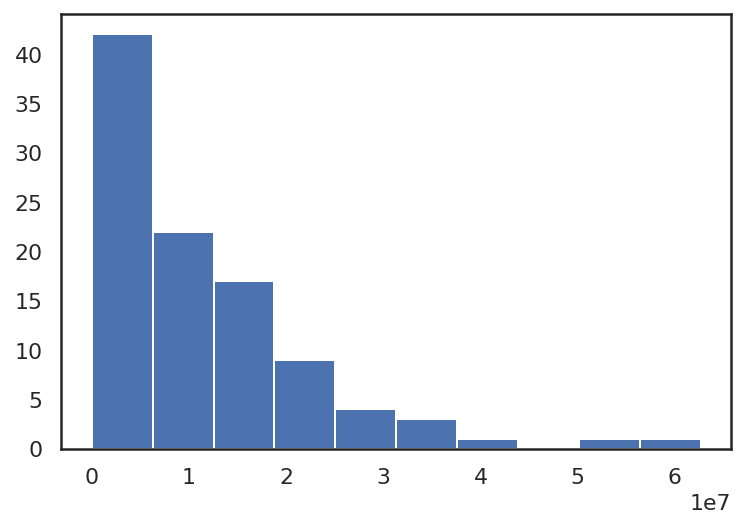

In [3]:
# dummy length data
from numpy.random import exponential
phys_lengths = exponential(scale=10000000, size=100) #+ 50000000
plt.hist(phys_lengths) ;

In [4]:
mean_rec_rate = 1e-8
lengths = phys_lengths * mean_rec_rate

In [5]:
phys_lengths.max(), lengths.max()

(62637650.93466677, 0.6263765093466677)

Human rec rate comparison

In [6]:
178.153765066457/146301156 #human chr8, cM/base

1.2177194626299262e-06

### Compute the empirical CDF

In [7]:
def ecdf(data):
    """ Compute ECDF """
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return x, y

val, prob = ecdf(lengths)

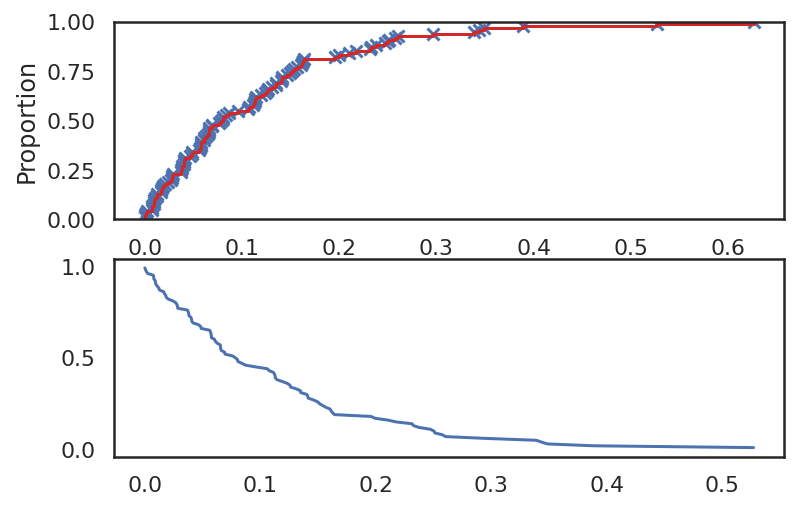

In [8]:
plt.subplot(211)
plt.scatter(val, prob, marker='x')
# sanity check
sns.ecdfplot(x=val, color='tab:red') 

# PDF
plt.subplot(212)
d, p = val[:-1], 1-prob[:-1] # leave out last one to avoid division by zero
plt.plot(d, p) ;

### Estimate the number of generations

The admixture is likely not the result of a single admixture event, but if we assume that it is, the length distribution of tracts is well approximated by $y=Ae^{−(n−1)d}$. Here $n$ is the number of generations since the admixture event and $d$ is genetic distance (physical length times mean recombination rate per base) and $A$ is a scaling factor. We fit a line to the log of the complementary cummulative distribution (the PDF) of tract lengths and, since $\ln(y)=−(n−1)d+\ln(A)$, the slope of the fitted line is n−1.

Intercept    0.035123
d           -9.305991
dtype: float64

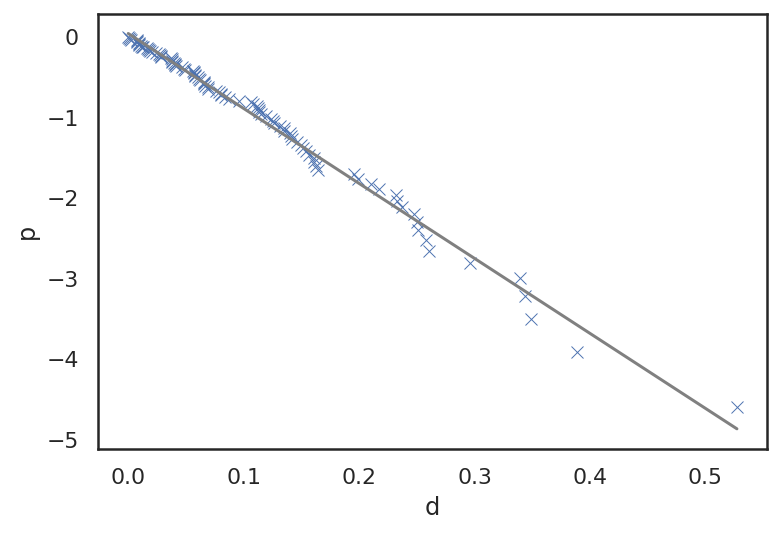

In [9]:
# mask = ~np.isnan(x)
# df = pd.DataFrame(dict(d=d[mask], p=np.log(1-p[mask])))

df = pd.DataFrame(dict(d=d, p=np.log(p)))

y, X = ps.dmatrices('p ~ d',data = df, return_type = 'dataframe')
model = sm.OLS(y,X)
results = model.fit()
predicted_p = results.predict()
p_residuals = df.p - predicted_p

ax = sns.scatterplot(x=df.d, y=df.p, marker='x');
ax.plot(df.d, predicted_p, color='grey', marker=None);
results.params

Generations since admixture pulse is:

In [10]:
round(-results.params.d + 1)

10

Repeating for the interesting individuals - Possibly autosomes for the Tarangire, and multiple autosomes for Issa Valley.

In [11]:
length_df_chr8_all = pd.read_csv("../steps/paint_summary/"+"length_df_chr8_all", sep=" ")

Assumption: Admixture can be well described as Northern ancestry versus southern ancestry.
In this case, this is probably close to the truth, as the ancestral background very clearly is olive, while the most recently admixing population is hamadryas.

In [12]:
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering.txt", sep =" ")

In [13]:
idfile_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/idfile_8_cluster.ids"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "pop", "inclusion"])
idfile["ID_index"] = idfile.index
idfile = idfile.loc[idfile.inclusion == 1]
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering.txt", sep =" ")
chrom = "chr8"
input_df = length_df_chr8_all
window_s = 10000

mapping = {}
for i, row in meta_data_samples.iterrows():
    if row.PGDP_ID[0] != "P":
        mapping["Sci_"+row.PGDP_ID] = row.Origin
    else:
        mapping[row.PGDP_ID] = row.Origin
c_mapping = {}
for donor in idfile["pop"].unique():
    IDs = idfile.loc[idfile["pop"] == donor].PGDP_ID.unique()
    c_mapping[donor] = meta_data_samples.loc[meta_data_samples.PGDP_ID.isin(IDs)].C_origin.unique()[0]
input_df["population"] = input_df["individual"].map(mapping)
input_df["chrom"] = ["chr{}".format(x) if str(x)[0] != "c" else x for x in input_df.chrom] # Some are read as int
horizon_list = []
meta_data_list = meta_data_samples.loc[(meta_data_samples.Origin == "Tarangire, Tanzania") & (meta_data_samples.Sex == "M")].PGDP_ID
for ind in meta_data_list:
    for hap in [1,2]:
        temp_horizon = length_to_windows(input_df.loc[(input_df.individual == ind)
                                                              & (input_df.chrom == chrom)
                                                     & (input_df.haplotype == hap)], window_size=window_s)
        temp_horizon["PGDP_ID"] = ind
        temp_horizon["ID_hap"] =ind+"hap"+str(hap)
        temp_horizon["chrom"] = chrom
        horizon_list.append(temp_horizon)
group_horizon = pd.concat(horizon_list)

In [14]:
input_df = group_horizon.loc[group_horizon.ID_hap == "PD_0266hap1"]
input_df["north"] = input_df.anubis_ethiopia+input_df.hamadryas+input_df.papio#+a_c_df.anubis_tanzania
input_df["admix"] = input_df.cyno_central
input_df["norm_north"] = (input_df.north-input_df.iloc[:,1:7].sum(axis=1)/2)
input_df["norm_admix"] = (input_df.admix-input_df.iloc[:,1:7].sum(axis=1)/2)
input_df["pop"] = input_df["PGDP_ID"].map(mapping)
input_df["start"] = input_df["windows"]
input_df["admix_l"] = ["Admix" if x >= 0 else "No_admix" for x in input_df["norm_admix"]]
input_df["N_S"] = ["North" if x >= window_s else "South" for x in input_df["norm_north"]]
shift_spots = (input_df["admix_l"] != input_df["admix_l"].shift())
spot_df = input_df.loc[shift_spots].copy()
spot_df["paint_length"] = (np.append(spot_df["windows"][1:].values, input_df.iloc[-1]["windows"])-spot_df["windows"].values)
spot_df["end_pos"] = (np.append(spot_df["windows"][1:].values, input_df.iloc[-1]["windows"])-1)
a_c_df = spot_df

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be

Loading mean rec rate

In [15]:
rec_file_path = "ldhat_conversion_chr{}_updated.txt"
dir_path = "/home/eriks/baboondiversity/data/PG_panu3_recombination_map/"
chrom = "8"
rec_file = pd.read_csv(dir_path+rec_file_path.format(chrom), sep=" ")
mean_rec = rec_file.iloc[-2]["Genetic_Map(cM)"]/(rec_file.iloc[-2]["position"])
lengths = a_c_df.loc[a_c_df.admix_l == "Admix"].paint_length*(mean_rec)

In [16]:
val, prob = ecdf(lengths.loc[lengths > 0.00001])

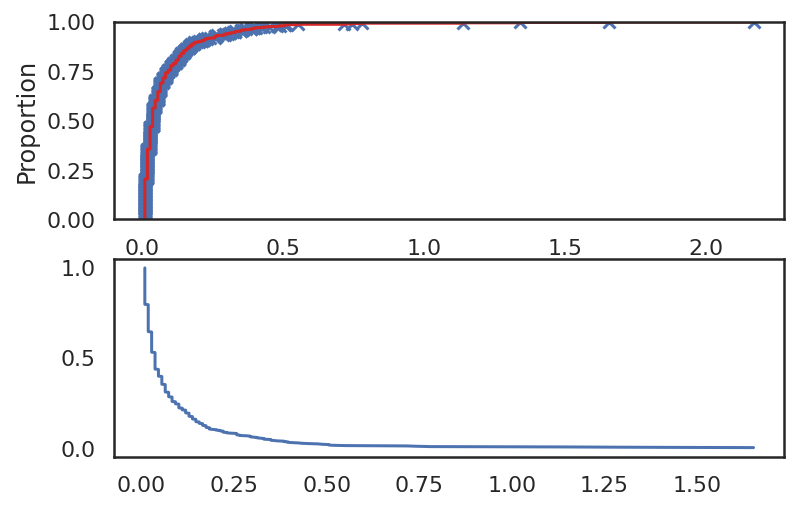

In [17]:
plt.subplot(211)
plt.scatter(val, prob, marker='x')
# sanity check
sns.ecdfplot(x=val, color='tab:red') 

# PDF
plt.subplot(212)
d, p = val[:-1], 1-prob[:-1] # leave out last one to avoid division by zero
plt.plot(d, p) ;

Intercept   -0.484538
d           -6.030169
dtype: float64

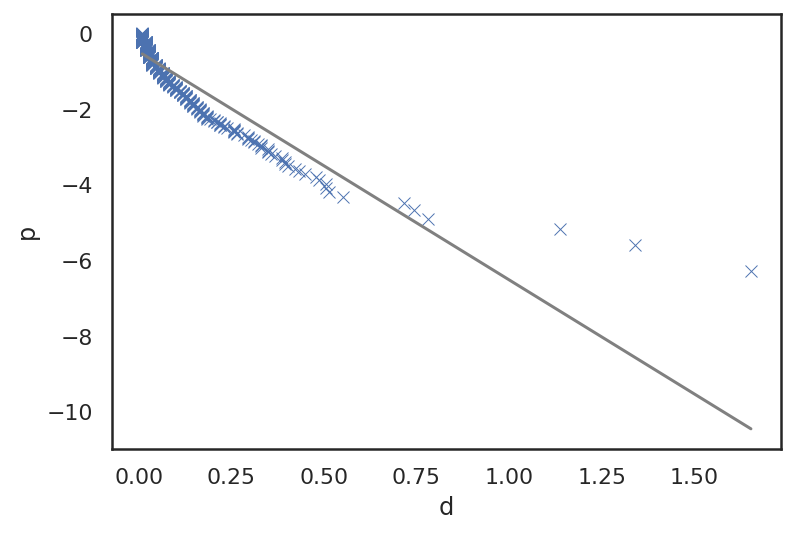

In [18]:
df = pd.DataFrame(dict(d=d, p=np.log(p)))

y, X = ps.dmatrices('p ~ d',data = df, return_type = 'dataframe')
model = sm.OLS(y,X)
results = model.fit()
predicted_p = results.predict()
p_residuals = df.p - predicted_p

ax = sns.scatterplot(x=df.d, y=df.p, marker='x');
ax.plot(df.d, predicted_p, color='grey', marker=None);
results.params

In [19]:
round(-(results.params.d+1))

5

In [20]:
low, high = results.conf_int(0.025).loc['d']
f"{round(-(results.params.d + 1))} 95% conf: {round(-(high+1))} - {round(-(low+1))}"

'5 95% conf: 5 - 5'

Redoing with North/South

In [21]:
df_l = []
for hap in ["1","2"]:
    input_df = group_horizon.loc[group_horizon.ID_hap == "PD_0266hap"+hap]
    input_df["north"] = input_df.anubis_ethiopia+input_df.hamadryas+input_df.papio#+a_c_df.anubis_tanzania
    input_df["admix"] = input_df.cyno_central
    input_df["norm_north"] = (input_df.north)-input_df.iloc[:,1:7].sum(axis=1)/2
    input_df["norm_admix"] = (input_df.admix)-input_df.iloc[:,1:7].sum(axis=1)/2
    input_df["pop"] = input_df["PGDP_ID"].map(mapping)
    input_df["start"] = input_df["windows"]
    input_df["admix_l"] = ["Admix" if x >= 0 else "No_admix" for x in input_df["norm_admix"]]
    input_df["N_S"] = ["North" if x >= window_s*0 else "South" for x in input_df["norm_north"]]
    shift_spots = (input_df["N_S"] != input_df["N_S"].shift())
    spot_df = input_df.loc[shift_spots].copy()
    spot_df["paint_length"] = (np.append(spot_df["windows"][1:].values, input_df.iloc[-1]["windows"])-spot_df["windows"].values)
    spot_df["end_pos"] = (np.append(spot_df["windows"][1:].values, input_df.iloc[-1]["windows"])-1)
    spot_df = spot_df.loc[spot_df.paint_length > window_s*2] #Removing small windows
    shift_spots = (spot_df["N_S"] != spot_df["N_S"].shift())
    spot_df = spot_df.loc[shift_spots].copy()
    spot_df["paint_length"] = (np.append(spot_df["windows"][1:].values, input_df.iloc[-1]["windows"])-spot_df["windows"].values)
    spot_df["end_pos"] = (np.append(spot_df["windows"][1:].values, input_df.iloc[-1]["windows"])-1)
    df_l.append(spot_df)
a_c_df = pd.concat(df_l)

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

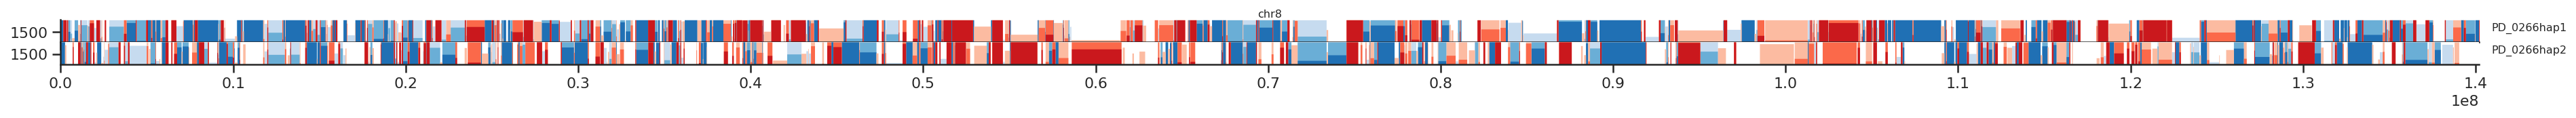

In [22]:
fig = horizonplot(a_c_df, 'norm_north', width=2, col='chrom', row='ID_hap', size=0.3, aspect=100)

In [23]:
rec_file_path = "ldhat_conversion_chr{}_updated.txt"
dir_path = "/home/eriks/baboondiversity/data/PG_panu3_recombination_map/"
chrom = "8"
rec_file = pd.read_csv(dir_path+rec_file_path.format(chrom), sep=" ")
mean_rec = rec_file.iloc[-2]["Genetic_Map(cM)"]/(rec_file.iloc[-2]["position"]*100)
lengths = a_c_df.loc[(a_c_df.N_S == "South") & (a_c_df.paint_length > 200000)].paint_length*(mean_rec)

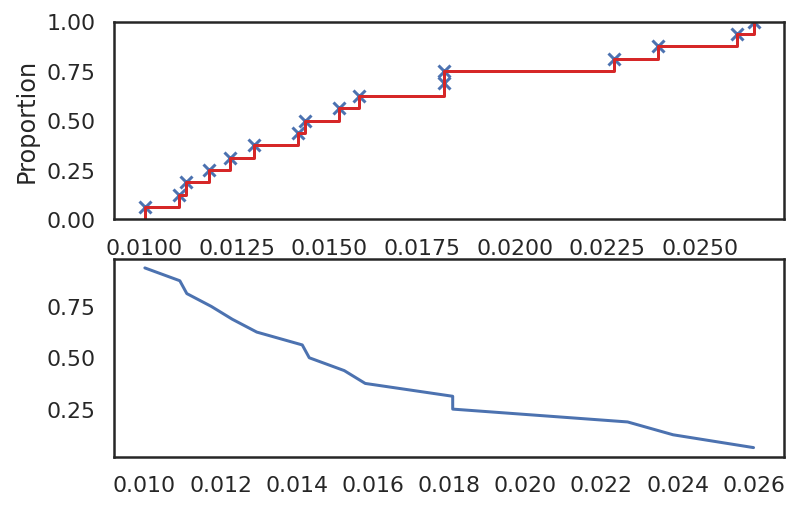

In [24]:
val, prob = ecdf(lengths.loc[(lengths > 0.01)])
plt.subplot(211)
plt.scatter(val, prob, marker='x')
# sanity check
sns.ecdfplot(x=val, color='tab:red') 

# PDF
plt.subplot(212)
d, p = val[:-1], 1-prob[:-1] # leave out last one to avoid division by zero
plt.plot(d, p) ;

Intercept      1.536353
d           -154.763269
dtype: float64

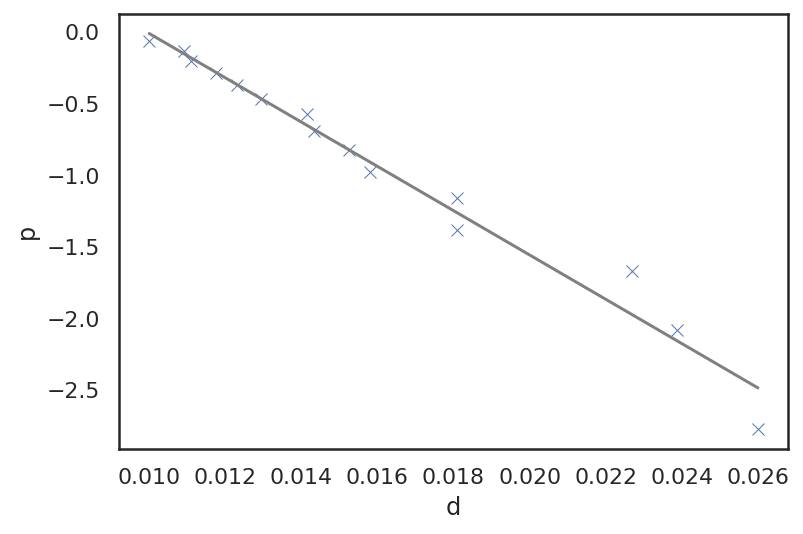

In [25]:
df = pd.DataFrame(dict(d=d, p=np.log(p)))

y, X = ps.dmatrices('p ~ d',data = df, return_type = 'dataframe')
model = sm.OLS(y,X)
results = model.fit()
predicted_p = results.predict()
p_residuals = df.p - predicted_p

ax = sns.scatterplot(x=df.d, y=df.p, marker='x');
ax.plot(df.d, predicted_p, color='grey', marker=None);
results.params

In [26]:
low, high = results.conf_int(0.025).loc['d']
f"{round(-(results.params.d + 1))} 95% conf: {round(-(high+1))} - {round(-(low+1))}"

'154 95% conf: 136 - 171'

Trying with the Issa Valley ind

Reading in all chromosomes

In [27]:
idfile_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/idfile_8_cluster.ids"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "pop", "inclusion"])
idfile["ID_index"] = idfile.index
recomb_map_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/chr{}/chr{}.filtered.all.recombfile"

idfile = idfile.loc[idfile.inclusion == 1]
os.makedirs("../steps/paint_summary/", exist_ok=True)
chrom_list = ['{}'.format(x) for x in range(1, 21)]
window_length = 100000
df_l = []
for chrom in chrom_list:
    recomb_map = pd.read_csv(recomb_map_path.format(chrom, chrom), sep=" ")
    pos_list = recomb_map["start.pos"]
    for population in ["cyno_western"]: # sorted(idfile["pop"].unique()):
        print(population, chrom)
        pop_path = "/home/eriks/baboondiversity/people/eriks/baboon_first_analysis/steps/" \
                        "all_autosomes_8_cluster/{}_all_autosomes_8_cluster/chr{}.samples.out"\
                        .format(population, chrom)
        length_df = create_paint_df_lengths(pop_path, idfile)
        length_df["chrom"] = "chr"+chrom
        length_df["C_origin"] = population
        df_l.append(length_df)
length_df_western_autosomes = pd.concat(df_l)

cyno_western 1
cyno_western 2
cyno_western 3
cyno_western 4
cyno_western 5
cyno_western 6
cyno_western 7
cyno_western 8
cyno_western 9
cyno_western 10
cyno_western 11
cyno_western 12
cyno_western 13
cyno_western 14
cyno_western 15
cyno_western 16
cyno_western 17
cyno_western 18
cyno_western 19
cyno_western 20


In [28]:
idfile_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/idfile_8_cluster.ids"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "pop", "inclusion"])
idfile["ID_index"] = idfile.index
idfile = idfile.loc[idfile.inclusion == 1]
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering.txt", sep =" ")
chrom_list = ['chr{}'.format(x) for x in range(1, 21)]
input_df = length_df_western_autosomes
window_s = 100000

mapping = {}
for i, row in meta_data_samples.iterrows():
    if row.PGDP_ID[0] != "P":
        mapping["Sci_"+row.PGDP_ID] = row.Origin
    else:
        mapping[row.PGDP_ID] = row.Origin
c_mapping = {}
for donor in idfile["pop"].unique():
    IDs = idfile.loc[idfile["pop"] == donor].PGDP_ID.unique()
    c_mapping[donor] = meta_data_samples.loc[meta_data_samples.PGDP_ID.isin(IDs)].C_origin.unique()[0]
input_df["population"] = input_df["individual"].map(mapping)
input_df["chrom"] = ["chr{}".format(x) if str(x)[0] != "c" else x for x in input_df.chrom] # Some are read as int
horizon_list = []
meta_data_list = meta_data_samples.loc[(meta_data_samples.Origin == "Issa Valley, Tanzania")].PGDP_ID
for chrom in chrom_list:
    for ind in meta_data_list:
        print(chrom, ind)
        for hap in [1,2]:
            temp_horizon = length_to_windows(input_df.loc[(input_df.individual == ind) & (input_df.chrom == chrom)
                                                             & (input_df.haplotype == hap)], window_size=window_s)
            temp_horizon["PGDP_ID"] = ind
            temp_horizon["ID_hap"] =ind+"hap"+str(hap)
            temp_horizon["chrom"] = chrom
            horizon_list.append(temp_horizon)
group_horizon_issa = pd.concat(horizon_list)

chr1 PD_0662
chr2 PD_0662
chr3 PD_0662
chr4 PD_0662
chr5 PD_0662
chr6 PD_0662
chr7 PD_0662
chr8 PD_0662
chr9 PD_0662
chr10 PD_0662
chr11 PD_0662
chr12 PD_0662
chr13 PD_0662
chr14 PD_0662
chr15 PD_0662
chr16 PD_0662
chr17 PD_0662
chr18 PD_0662
chr19 PD_0662
chr20 PD_0662


In [29]:
df_l = []
for chrom in chrom_list:
    for hap in ["1","2"]:
        input_df = group_horizon_issa.loc[(group_horizon_issa.ID_hap == "PD_0662hap"+hap)
                                          & (group_horizon_issa.chrom == chrom)]
        input_df["north"] = input_df.anubis_ethiopia+input_df.hamadryas+input_df.papio+input_df.anubis_tanzania
        input_df["admix"] = input_df.cyno_central
        input_df["norm_north"] = (input_df.north)-input_df.iloc[:,1:7].sum(axis=1)/2
        input_df["norm_admix"] = (input_df.admix)-input_df.iloc[:,1:7].sum(axis=1)/2
        input_df["pop"] = input_df["PGDP_ID"].map(mapping)
        input_df["start"] = input_df["windows"]
        input_df["admix_l"] = ["Admix" if x >= 0 else "No_admix" for x in input_df["norm_admix"]]
        input_df["N_S"] = ["North" if x >= 0 else "South" for x in input_df["norm_north"]] #Picking a value higher than 0
        # to not break up chunks of overwhelming southern ancestry
        shift_spots = (input_df["N_S"] != input_df["N_S"].shift())
        spot_df = input_df.loc[shift_spots].copy()
        spot_df["paint_length"] = (np.append(spot_df["windows"][1:].values, input_df.iloc[-1]["windows"])-spot_df["windows"].values)
        spot_df["end_pos"] = (np.append(spot_df["windows"][1:].values, input_df.iloc[-1]["windows"])-1)
        spot_df = spot_df.loc[spot_df.paint_length > window_s*2] #Removing small windows
        shift_spots = (spot_df["N_S"] != spot_df["N_S"].shift())
        spot_df = spot_df.loc[shift_spots].copy()
        spot_df["paint_length"] = (np.append(spot_df["windows"][1:].values, input_df.iloc[-1]["windows"])-spot_df["windows"].values)
        spot_df["end_pos"] = (np.append(spot_df["windows"][1:].values, input_df.iloc[-1]["windows"])-1)
        df_l.append(spot_df)
issa = pd.concat(df_l)

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [30]:
fig = horizonplot(issa, 'norm_north', width=2, col='chrom', row='ID_hap', size=0.3, aspect=100)

ValueError: Image size of 86400x86 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 43200x43.2 with 40 Axes>

In [31]:
for chrom in chrom_list:
    rec_file_path = "ldhat_conversion_{}_updated.txt"
    dir_path = "/home/eriks/baboondiversity/data/PG_panu3_recombination_map/"
    rec_file = pd.read_csv(dir_path+rec_file_path.format(chrom), sep=" ")
    mean_rec = rec_file.iloc[-2]["Genetic_Map(cM)"]/(rec_file.iloc[-2]["position"]*100)
    print(mean_rec)

7.701281838412216e-09
7.408502203547763e-09
8.051744505517154e-09
9.141276338186882e-09
7.74568303982335e-09
7.49902674931896e-09
8.304177743629542e-09
9.18582074318103e-09
9.624497972453124e-09
1.0680135546913238e-08
8.737931666183884e-09
8.52710309019089e-09
9.45648009167479e-09
8.360896947123346e-09
9.163014187180756e-09
1.198151854869039e-08
1.0625712442287324e-08
1.0307615644018582e-08
1.5348789259852615e-08
1.075234599655199e-08


In [32]:
rec_file_path = "ldhat_conversion_chr{}_updated.txt"
dir_path = "/home/eriks/baboondiversity/data/PG_panu3_recombination_map/"
chrom = "8"
rec_file = pd.read_csv(dir_path+rec_file_path.format(chrom), sep=" ")
mean_rec = rec_file.iloc[-2]["Genetic_Map(cM)"]/(rec_file.iloc[-2]["position"]*100)
lengths = issa.loc[(issa.N_S == "North") & (issa.paint_length > 100000)].paint_length*(mean_rec)

[None]

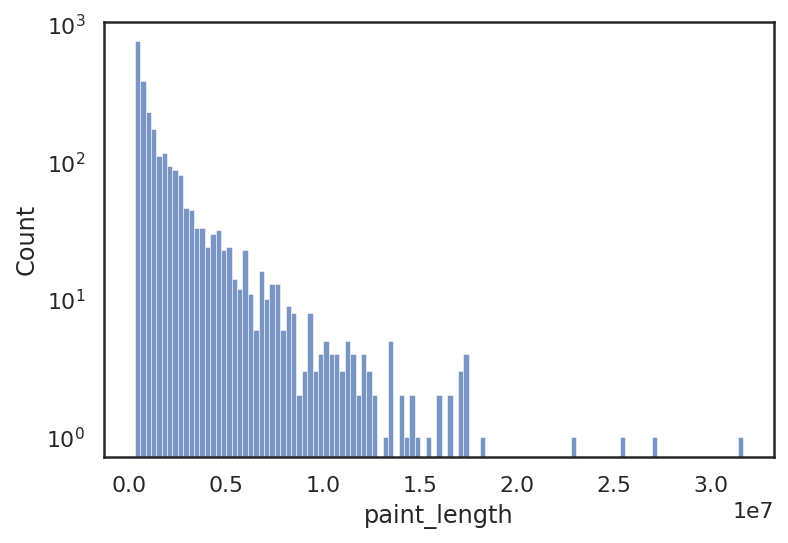

In [33]:
g = sns.histplot(data=issa, x="paint_length")
g.set(yscale="log")

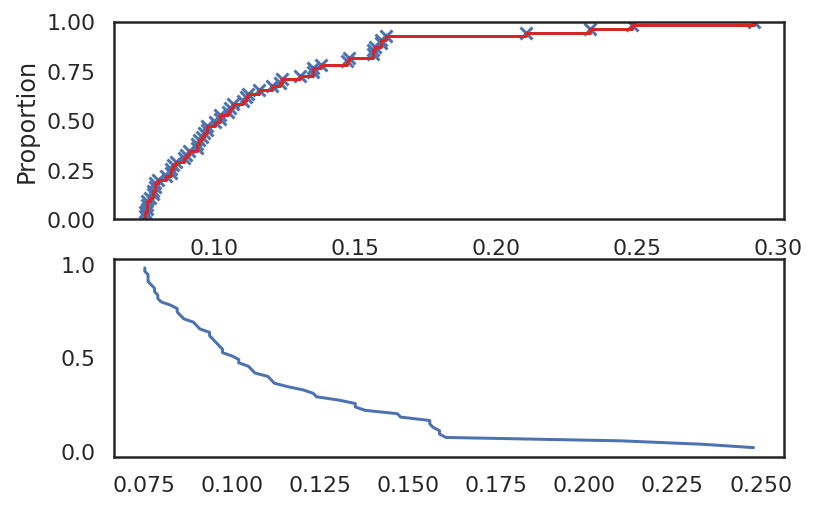

In [49]:
val, prob = ecdf(lengths.loc[(lengths > 0.075)])
plt.subplot(211)
plt.scatter(val, prob, marker='x')
# sanity check
sns.ecdfplot(x=val, color='tab:red') 

# PDF
plt.subplot(212)
d, p = val[:-1], 1-prob[:-1] # leave out last one to avoid division by zero
plt.plot(d, p) ;

Intercept     1.599094
d           -22.606712
dtype: float64

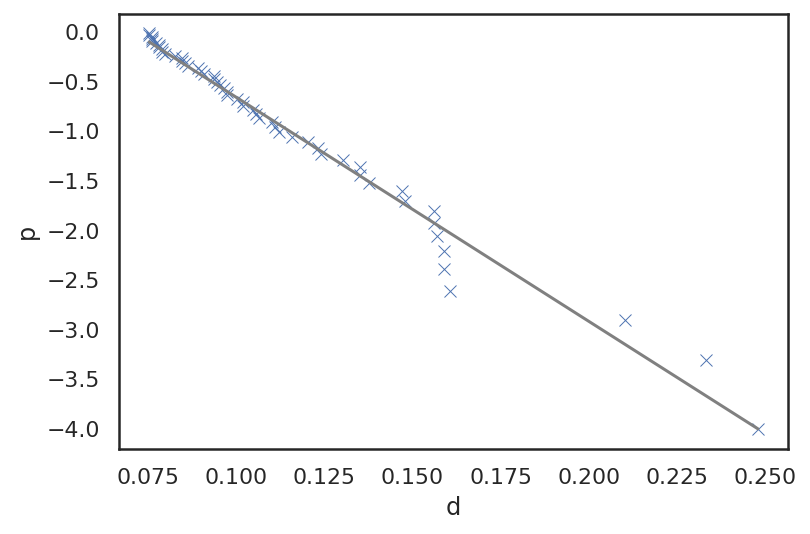

In [50]:
df = pd.DataFrame(dict(d=d, p=np.log(p)))

y, X = ps.dmatrices('p ~ d',data = df, return_type = 'dataframe')
model = sm.OLS(y,X)
results = model.fit()
predicted_p = results.predict()
p_residuals = df.p - predicted_p

ax = sns.scatterplot(x=df.d, y=df.p, marker='x');
ax.plot(df.d, predicted_p, color='grey', marker=None);
results.params

In [51]:
low, high = results.conf_int(0.025).loc['d']
f"{round(-(results.params.d + 1))} 95% conf: {round(-(high+1))} - {round(-(low+1))}"

'22 95% conf: 21 - 23'